## Question 1.1


In [25]:
!pip install torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as TorchFunc
import cv2
from torchinfo import summary
import numpy as np
import os
from google.colab import drive
import math
drive.mount('/content/drive')  # Mount Google Drive

class Tanh(nn.Module):
    def forward(self, x):
        return 1.7159 * torch.tanh(x * (2 / 3))

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # C1: Convolutional layer (6 feature maps, 5x5 kernel)
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        nn.init.kaiming_uniform_(self.c1.weight, a=math.sqrt(2))
        nn.init.constant_(self.c1.bias, 0.01)

        # S2: Subsampling layer (average pooling)
        self.kernel_s2 = 2
        self.stride_s2 = 2
        self.s2_weight = nn.Parameter(torch.Tensor(1, 6, 1, 1))
        self.s2_bias = nn.Parameter(torch.Tensor(1, 6, 1, 1))
        nn.init.kaiming_uniform_(self.s2_weight, a=math.sqrt(1))
        nn.init.constant_(self.s2_bias, 0.01)

        # C3: Convolutional layer (16 feature maps, selective connections, 5x5 kernel)
        self.c3_weight = nn.Parameter(torch.Tensor(10, 6, 5, 5))
        self.c3_bias = nn.Parameter(torch.Tensor(1, 16, 1, 1))
        nn.init.kaiming_uniform_(self.c3_weight, a=math.sqrt(2))
        nn.init.constant_(self.c3_bias, 0.01)

        # S4: Subsampling layer (average pooling)
        self.kernel_s4 = 2
        self.stride_s4 = 2
        self.s4_weight = nn.Parameter(torch.Tensor(1, 16, 1, 1))
        self.s4_bias = nn.Parameter(torch.Tensor(1, 16, 1, 1))
        nn.init.kaiming_uniform_(self.s4_weight, a=math.sqrt(1))
        nn.init.constant_(self.s4_bias, 0.01)

        # C5: Fully connected convolutional layer (120 feature maps, 5x5 kernel)
        self.c5 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        nn.init.kaiming_uniform_(self.c5.weight, a=math.sqrt(2))
        nn.init.constant_(self.c5.bias, 0.01)

        # F6: Fully connected layer (120 -> 84)
        self.f6 = nn.Linear(120, 84)
        nn.init.kaiming_uniform_(self.f6.weight, a=math.sqrt(2))
        nn.init.constant_(self.f6.bias, 0.01)

        # RBF Layer
        self.rbf = RBF()

        # Activation function
        self.tanh = Tanh()

    def forward(self, x):
        # C1
        x = self.c1(x)
        x = self.tanh(x)

        # S2
        x = TorchFunc.avg_pool2d(x, kernel_size=self.kernel_s2, stride=self.stride_s2)
        x = x * self.s2_weight + self.s2_bias
        x = self.tanh(x)

        # C3
        B_size = x.size(0)
        output_size = x.size(3) - 5 + 1
        output = torch.zeros(B_size, 16, output_size, output_size).to(x.device)
        connection_list = self._map_combine_list()
        for i in range(len(connection_list)):
            output[:, connection_list[i], :, :] += (
                TorchFunc.conv2d(
                    x[:, i, :, :].unsqueeze(1),
                    self.c3_weight[:, i, :, :].unsqueeze(1),
                ) + self.c3_bias[:, connection_list[i], :, :]
            )
        x = output
        x = self.tanh(x)

        # S4
        x = TorchFunc.avg_pool2d(x, kernel_size=self.kernel_s4, stride=self.stride_s4)
        x = x * self.s4_weight + self.s4_bias
        x = self.tanh(x)

        # C5
        x = self.c5(x)
        x = self.tanh(x)

        # Flatten for fully connected layers
        x = torch.flatten(x, start_dim=1)

        # F6
        x = self.f6(x)
        x = self.tanh(x)

        # RBF
        x = self.rbf(x)

        return x

    def _map_combine_list(self):
        return [
            [0, 4, 5, 6, 9, 10, 11, 12, 14, 15],
            [0, 1, 5, 6, 7, 10, 11, 12, 13, 15],
            [0, 1, 2, 6, 7, 8, 11, 13, 14, 15],
            [1, 2, 3, 6, 7, 8, 9, 12, 14, 15],
            [2, 3, 4, 7, 8, 9, 10, 12, 13, 15],
            [3, 4, 5, 8, 9, 10, 11, 13, 14, 15],
        ]

class RBF(nn.Module):
    def __init__(self):
        super(RBF, self).__init__()
        self.number_image_list = self.get_prototype_vectors()

    def get_prototype_vectors(self):
      kernel_list = []
      for label in range(10):  # Assume folders are named 0 to 9
          folder_path = f"/content/drive/MyDrive/MLHW4/digits/{label}"
          digit_images = [
              cv2.resize(cv2.imread(os.path.join(folder_path, file), 0), (7, 12))
              for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))
          ]
          if digit_images:
              mean_image = np.mean(digit_images, axis=0)
              binarized_image = (cv2.threshold(mean_image, 127, 1, cv2.THRESH_BINARY)[1]
                                .astype(np.int16) * -1 + 1)
              kernel_list.append(binarized_image.flatten())
      return torch.tensor(kernel_list, dtype=torch.float32)


    def forward(self, x):
        size = (x.size(0), 10, 84)
        more_dimensional_x = x.unsqueeze(1).expand(size)
        number_image_list_parameters = self.number_image_list.unsqueeze(0).expand(size)
        output = (more_dimensional_x - number_image_list_parameters).pow(2).sum(-1)
        return output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
model = LeNet5()
summary(model, (1, 1, 32, 32))

<ipython-input-25-d1e616cd44f7>:138: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(kernel_list, dtype=torch.float32)


Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   1,560
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─Tanh: 1-2                              [1, 6, 28, 28]            --
├─Tanh: 1-3                              [1, 6, 14, 14]            --
├─Tanh: 1-4                              [1, 16, 10, 10]           --
├─Tanh: 1-5                              [1, 16, 5, 5]             --
├─Conv2d: 1-6                            [1, 120, 1, 1]            48,120
├─Tanh: 1-7                              [1, 120, 1, 1]            --
├─Linear: 1-8                            [1, 84]                   10,164
├─Tanh: 1-9                              [1, 84]                   --
├─RBF: 1-10                              [1, 10]                   --
Total params: 60,000
Trainable params: 60,000
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass siz

## Question 1.2

In [27]:

import torch.optim as optim
from PIL import Image
import io
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.nn.functional as TorchFunc

import pandas as pd
from PIL import Image



splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])


transform = transforms.Compose([
    transforms.PILToTensor()
])


def get_images(data_frame):
  images = []
  labels = []

  for row in data_frame.itertuples():
    image = Image.open(io.BytesIO(row[1]['bytes']))
    transformed_image = transform(image)
    images.append(transformed_image)
    label = row[2]
    labels.append(label)


  images_stacked = torch.stack(images)
  labels_stacked = torch.tensor(labels, dtype=torch.long)

  return images_stacked, labels_stacked

train_images_stacked, train_labels_stacked = get_images(df_train)
test_images_stacked, test_labels_stacked = get_images(df_test)


train_loader = DataLoader(TensorDataset(train_images_stacked, train_labels_stacked), batch_size = 64, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images_stacked, test_labels_stacked), batch_size = 64, shuffle=True)


def train_and_test(model, epoch):
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    def calculate_loss(prediction, label):
        loss_1 = (prediction[label == 1]).pow(2).sum()
        loss_2 = torch.log(torch.exp(torch.tensor(-0.1)) + torch.exp(-prediction[label == 0]).sum())
        total_loss = loss_1 + loss_2
        average_loss = (total_loss) / prediction.size(0)

        return average_loss

    train_accuracy = []
    test_accuracy = []

    for i in range(epoch):
        total_accuracy = 0

        for data, label in train_loader:
            float_data = data.float()
            padded_data = TorchFunc.pad(float_data, pad=(2, 2, 2, 2), mode='constant', value=-0.1)

            label = nn.functional.one_hot(label, num_classes = 10).float()
            optimizer.zero_grad()

            prediction = model(padded_data)
            loss = calculate_loss(prediction, label)

            loss.backward()
            optimizer.step()

            total_accuracy += (torch.argmin(prediction, dim=1) == torch.argmax(label, dim=1)).sum().item()

        average_accuracy = total_accuracy / len(train_loader.dataset)
        train_accuracy.append(average_accuracy)

        if i % 1 == 0:
            print('epoch : {}/{}, train_accuracy : {:.2f}'.format(i + 1, epoch, average_accuracy))

        total_test_accuracy = 0
        with torch.no_grad():
          for data, label in test_loader:
            float_data = data.float()
            padded_data = TorchFunc.pad(float_data, pad=(2, 2, 2, 2), mode='constant', value=-0.1)

            prediction = model(padded_data)
            total_test_accuracy += (torch.argmin(prediction, dim=1) == label).sum().item()

          average_accuracy = total_test_accuracy / len(test_loader.dataset)
          test_accuracy.append(average_accuracy)
          print(f"Test_accuracy: {average_accuracy}")


    return train_accuracy, test_accuracy


train_accuracy, test_accuracy = train_and_test(model, 20)


epoch : 1/20, train_accuracy : 0.80
Test_accuracy: 0.9314
epoch : 2/20, train_accuracy : 0.94
Test_accuracy: 0.9468
epoch : 3/20, train_accuracy : 0.95
Test_accuracy: 0.9592
epoch : 4/20, train_accuracy : 0.96
Test_accuracy: 0.9644
epoch : 5/20, train_accuracy : 0.96
Test_accuracy: 0.9673
epoch : 6/20, train_accuracy : 0.96
Test_accuracy: 0.9613
epoch : 7/20, train_accuracy : 0.97
Test_accuracy: 0.966
epoch : 8/20, train_accuracy : 0.97
Test_accuracy: 0.9707
epoch : 9/20, train_accuracy : 0.97
Test_accuracy: 0.9661
epoch : 10/20, train_accuracy : 0.97
Test_accuracy: 0.9746
epoch : 11/20, train_accuracy : 0.97
Test_accuracy: 0.9746
epoch : 12/20, train_accuracy : 0.97
Test_accuracy: 0.975
epoch : 13/20, train_accuracy : 0.97
Test_accuracy: 0.9763
epoch : 14/20, train_accuracy : 0.98
Test_accuracy: 0.9757
epoch : 15/20, train_accuracy : 0.98
Test_accuracy: 0.9752
epoch : 16/20, train_accuracy : 0.98
Test_accuracy: 0.9789
epoch : 17/20, train_accuracy : 0.98
Test_accuracy: 0.9794
epoch : 

In [28]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the save path in Google Drive
save_path = "/content/drive/MyDrive/MLHW4/LeNet_1.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/MLHW4/LeNet_1.pth


## Question 1.3

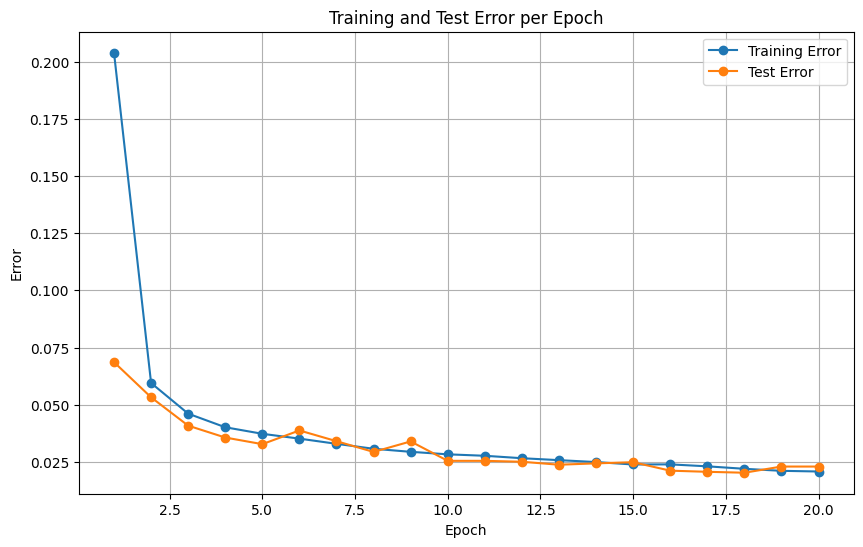

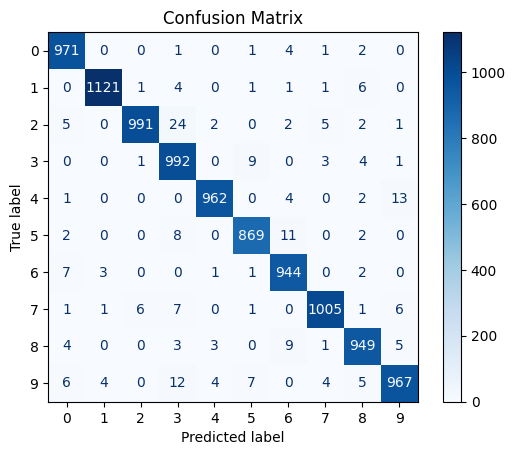

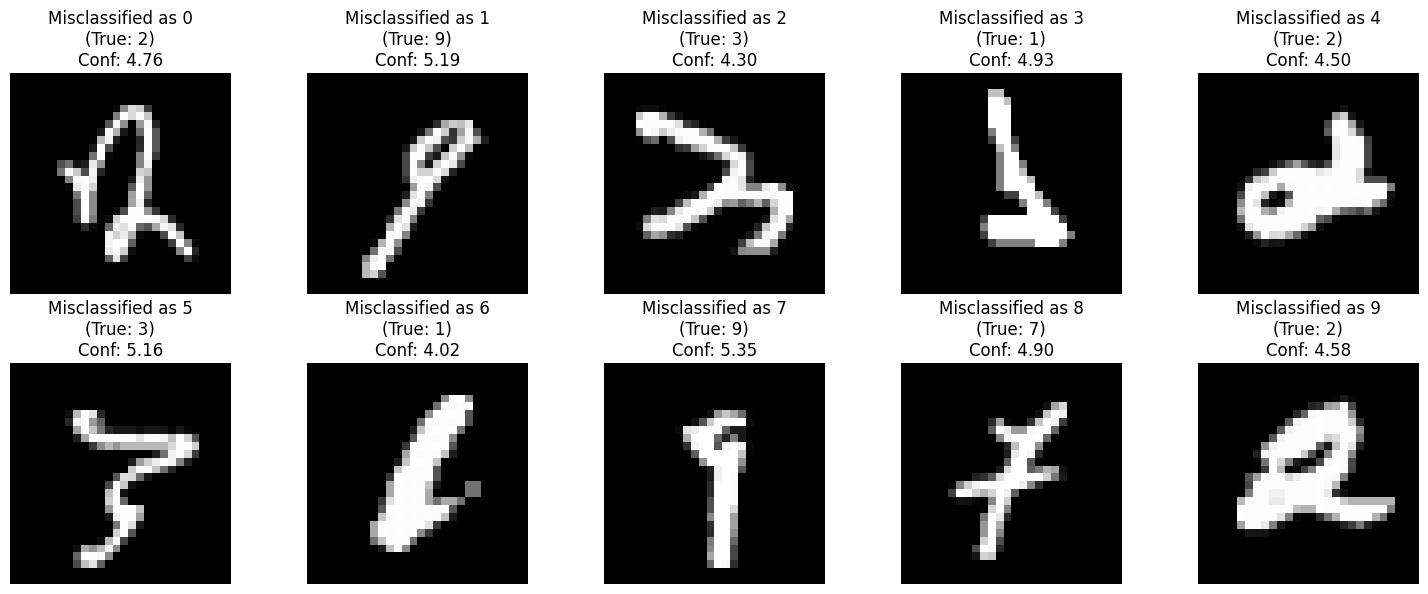

In [29]:
#1.3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as TorchFunc
import numpy as np
import matplotlib.pyplot as plt



#Create Plot
train_error = []
test_error = []

for i in range(len(test_accuracy)):
  train_error.append(1 - train_accuracy[i])
  test_error.append(1 - test_accuracy[i])


def plot_errors(train_errors, test_errors):
  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_errors) + 1)
  plt.plot(epochs, train_errors, label='Training Error', marker='o')
  plt.plot(epochs, test_errors, label='Test Error', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.title('Training and Test Error per Epoch')
  plt.legend()
  plt.grid(True)
  plt.show()


def create_confusion_matrix(model):
  predictions = []
  labels = []

  model.eval()
  with torch.no_grad():
    for data, label in test_loader:
      float_data = data.float()
      padded_data = TorchFunc.pad(float_data, pad=(2, 2, 2, 2), mode='constant', value=-0.1)

      prediction = model(padded_data)
      predicted_labels = torch.argmin(prediction, dim=1)

      predictions.extend(predicted_labels.cpu().numpy())
      labels.extend(label.cpu().numpy())

  # Compute the confusion matrix
  cm = confusion_matrix(labels, predictions)

  # Display the confusion matrix
  display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
  display.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()


def confusing_examples(model, test_loader):
  model.eval()


  confusing_examples = {digit: {"image": None, "true_label": None, "confidence": -1} for digit in range(10)}

  with torch.no_grad():
    for data, labels in test_loader:
      float_data = data.float()
      padded_data = TorchFunc.pad(float_data, pad=(2, 2, 2, 2), mode='constant', value=-0.1)

      prediction = model(padded_data)
      predicted_labels = torch.argmin(prediction, dim=1)

      for i in range(len(labels)):
        true_label = labels[i].item()
        predicted_label = predicted_labels[i].item()

        if true_label != predicted_label:
          confidence = prediction[i, predicted_label].item()

          if confidence > confusing_examples[predicted_label]["confidence"]:
            confusing_examples[predicted_label]["image"] = float_data[i]
            confusing_examples[predicted_label]["true_label"] = true_label
            confusing_examples[predicted_label]["confidence"] = confidence

  return confusing_examples



plot_errors(train_error, test_error)
create_confusion_matrix(model)
most_confusing = confusing_examples(model, test_loader)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (digit, info) in enumerate(most_confusing.items()):
    ax = axes[idx]
    if info["image"] is not None:
        ax.imshow(info["image"].squeeze(), cmap="gray")
        ax.set_title(f"Misclassified as {digit}\n(True: {info['true_label']})\nConf: {info['confidence']:.2f}")
    else:
        ax.set_title(f"No Example for {digit}")
    ax.axis("off")


plt.tight_layout()
plt.show()


